[Training](#Training)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from collections import Counter
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, classification_report, RocCurveDisplay, roc_auc_score, roc_curve, ConfusionMatrixDisplay, \
    precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
import random
import os

In [ ]:
path = '../Data/df_clean_null.pkl'
df = pd.read_pickle(path)

In [ ]:
feature_names = ['_RFHLTH', '_HCVU651', '_RFHYPE5', '_RFCHOL', '_ASTHMS1', '_DRDXAR1', '_RACEGR3', '_AGE_G', '_BMI5CAT', '_EDUCAG', '_INCOMG', '_SMOKER3',\
    '_RFDRHV5', '_PACAT1', '_RFSEAT2', '_FLSHOT6', '_PNEUMO2', '_AIDTST3', 'CHCCOPD1', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'SEX', 'MARITAL', 'DRADVISE']
target_name = ['_MICHD']
weights_name = ['_LLCPWT'] 

In [ ]:
df = df[feature_names + target_name + weights_name]
df

In [ ]:
for column in ['_RFHYPE5', '_RFCHOL', '_RFDRHV5']:
    df[column] = df[column].apply(lambda x: 1.0 if x == 2.0 else 2.0 if x == 1.0 else x)

In [ ]:
for column in ['_FLSHOT6', '_PNEUMO2']:
    df[column] = df[column].cat.add_categories([65.0])
    df[column] = df[column].fillna(65.0)

In [ ]:
df['DIABETE3'] = df['DIABETE3'].map({1.0:1.0, 2.0:1.0, 3.0:2.0, 4.0:2.0, 7.0:7.0, 9.0:9.0}).astype('category')

In [ ]:
df['_MICHD'] = df['_MICHD'].apply(lambda x: 0.0 if x == 2 else x)

In [ ]:
def imputer(dataframe, category_value_tofill=None, columns_drop=None, columns_mode=None, columns_median=None):
    '''Imputes missing values to the input dataframe.
    
       Parameters
       ----------
       dataframe: Pandas dataframe
           dataframe with which to impute missing values.
       
       category_value_tofill: int, float, or string
           Value to used to fill missing values in categorical features.
       
       columns_drop: list-like
           List of columns to drop.
       
       columns_mode: list-like
           List of numeric columns to impute with the mode.
           
       columns_median: list-like
           List of numeric columns to impute with the mean.
    '''
    #Fill null values in categorical features with value_null
    if category_value_tofill != None:
        for column in dataframe.select_dtypes(include='category').columns:
            if any(dataframe[column].isnull()):
                dataframe[column] = dataframe[column].cat.add_categories([category_value_tofill])
                dataframe[column] = dataframe[column].fillna(value=category_value_tofill)
            
    #Droping columns, imputing with mode, and imputing with median.
    if columns_drop != None:
        dataframe = dataframe.drop(columns=columns_drop)
    if columns_mode != None:
        dataframe = dataframe.fillna(dataframe[columns_mode].mode().iloc[0, :])
    if columns_median != None:
        dataframe = dataframe.fillna(dataframe[columns_median].median())
    
    return dataframe

In [ ]:
df = imputer(df, 999.0)

In [ ]:
trans_list = ['Good_Health', 'Health_Insurance', 'Hypertension', 'High_Cholesterol', 'Asthma_Status', 'Arthritis', 'Race', 'Age_Cat', 'BMI_Cat', 'Education_Level', 'Income_Level', \
    'Smoker_Status', 'Heavy_Drinker', 'Physical_Activity', 'Seatbelt', 'Flu_Shot', 'Pneumonia_Vaccine', 'HIV', 'Bronchitis', 'Depression', 'Kidney_Disease', 'Diabetes', 'SEX', \
        'Marital Status', 'Sodium', 'Heart_Disease', 'Sample_Weights']

In [ ]:
trans_dict = dict(zip(feature_names + target_name + weights_name, trans_list))
trans_dict

In [ ]:
df = df.rename(columns=trans_dict)
df

In [ ]:
df = df.drop(df[df[trans_dict[target_name[0]]] == 999.0].index)

In [ ]:
cols_to_one_hot = [column for column in df.select_dtypes(include='category').columns if column not in ['Heart_Disease']]

column_trans = ColumnTransformer([('categorical', OneHotEncoder(sparse=False), cols_to_one_hot)], remainder='passthrough')
column_trans.fit(df)
column_names_trans = np.concatenate([column_trans.named_transformers_['categorical'].get_feature_names_out(), np.array([trans_dict[target_name[0]], trans_dict[weights_name[0]]])])

In [ ]:
df = pd.DataFrame(column_trans.transform(df), columns=column_names_trans)
df

In [ ]:
with open('../Data/modeling_df.pkl', 'wb') as f:
    pickle.dump(df, f)
    pickle.dump(trans_dict, f)

## Training

In [2]:
with open('../Data/modeling_df.pkl', 'rb') as f:
    df = pickle.load(f)
    
y = df['Heart_Disease']
w = df['Sample_Weights']
X = df.drop(columns=[y.name, w.name])

In [3]:
class LogisticRegressionCustom(LogisticRegression):
    def __init__(self, max_iter=100, class_weight=None, threshold=None):
        super().__init__(max_iter=max_iter, class_weight=class_weight)
        self.threshold = threshold
    
    def predict(self, X):
        if self.threshold != None:
            return (super().predict_proba(X)[:, 1] >= self.threshold).astype(int)
        else:
            return super().predict(X)

In [4]:
def plot_logistic_feature_importance(coefficients, feature_names, number):
    coef_enum = enumerate(coefficients)
    coef_enum_sorted_top = sorted(coef_enum, key=lambda x: abs(x[1]), reverse=True)[:number]
    
    indices = list(list(zip(*coef_enum_sorted_top))[0])
    names = feature_names[indices]
    top_coef = np.array(list(zip(*coef_enum_sorted_top))[1])
    
    neg_pos = np.where(top_coef < 0)[0]
    pos_pos = np.where(top_coef >= 0)[0]
    neg_coef = top_coef[neg_pos]
    pos_coef = top_coef[pos_pos]
    neg_names = names[neg_pos]
    pos_names = names[pos_pos]
    
    _, ax = plt.subplots()
    
    ax.bar(neg_pos, np.abs(neg_coef), color='r', label='Negative')
    ax.bar(pos_pos, np.abs(pos_coef), color='b', label='Positive')
    ax.set_xticks(range(0, len(names)))
    ax.set_xticklabels(names, rotation=90)
    ax.set_title('Top Features by Absolute Value of Model Coefficient')
    ax.set_ylabel('Feature Coefficient')
    ax.set_xlabel('Features')
    
    ax.legend()
    plt.show()

In [5]:
def find_threshold(y_true, y_proba, set_tpr, sample_weight=None):
    _, tpr_list, threshold_list = roc_curve(y_true, y_proba, sample_weight=sample_weight)
    for tpr, threshold in zip(tpr_list, threshold_list):
        if (tpr >= set_tpr):
            return tpr, threshold

In [6]:
def my_scorer(y_test, y_pred, y_pred_proba=None, sample_weight=None, model_name=None, output=True):
    prfs_scores = precision_recall_fscore_support(y_test, y_pred, sample_weight=sample_weight)
    roc_auc_score_ = roc_auc_score(y_test, y_pred, sample_weight=sample_weight)
    scores = *prfs_scores, roc_auc_score_
    
    cf_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, sample_weight=sample_weight, normalize = 'true')
    if output == True:
        if type(model_name) != type(None):
            plt.title(model_name)
        plt.show()
        print()
        
    if output == True:
        print(f'Classification Report: {model_name if type(model_name) != type(None) else ""}')
    class_report = classification_report(y_test, y_pred, sample_weight=sample_weight)
    if output == True:
        print(class_report)
        print()
    
    if type(y_pred_proba) != type(None):
        roc_display = RocCurveDisplay.from_predictions(y_test, y_pred_proba, sample_weight=sample_weight)
        if output == True:
            if model_name != None:
                plt.title(model_name)
            plt.show()
    else:
        roc_display = None
        
    return scores, (cf_display, class_report, roc_display)

In [7]:
def my_pipeline(ml_algo, *data, model_name=None, algo_params={}, resampler=None, split_params={}, output=True):
    if len(data) not in [2, 3]:
        print('Invalid length for "data".')
        return
    
    results = {}
    
    split_result = train_test_split(*data, **split_params)
    if len(split_result) == 4:
        X_train, X_test, y_train, y_test = split_result
        w_train = None
        w_test = None
    elif len(split_result) == 6:
        X_train, X_test, y_train, y_test, w_train, w_test = split_result
    else:
        print('Invalid length for "split_result".')
        return
        
    if type(resampler) != type(None):
        X_train, y_train = resampler().fit_resample(X_train, y_train)
    
    model = ml_algo(**algo_params)
    model.fit(X_train, y_train, sample_weight=w_train)
    results['model_info'] = model_name, model
    
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba_train = None
        y_pred_proba = None
        
    results['predictions_train'] = y_pred_train, y_pred_proba_train
    results['predictions'] =y_pred, y_pred_proba
    
    results['scores_train'], results['displays_train'] = my_scorer(y_train, y_pred_train, y_pred_proba_train, sample_weight=w_train, model_name=model_name + ' (train)', output=output)
    results['scores'], results['displays'] = my_scorer(y_test, y_pred, y_pred_proba, sample_weight=w_test, model_name=model_name, output=output)
    
    return results


In [13]:
def cv_scorer(ml_algo, scoring, *data, model_name=None, algo_params={}, resampler=None, output=True):    
    if len(data) == 2:
        X, y = tuple(data)
        w = None
    elif len(data) == 3:
        X, y, w = tuple(data)
    else:
        print('Invalid length for "data".')
        return
    
    if type(resampler) != type(None):
        model = Pipeline([('Resampling', resampler()), (model_name, ml_algo(**algo_params))])
    else:
        model = Pipeline([(model_name, ml_algo(**algo_params))])
    
    cv_scores = cross_validate(model, X, y, scoring=scoring, fit_params={model_name + '__sample_weight':w})
    if output == True:
        if type(model_name) != type(None):
            print(model_name + ' cv_scores:')
        else:
            print('cv_scores:')
        print(cv_scores)
        print()
    
    dict_scores = {}
    for score in scoring:
        scores_ = cv_scores['test_' + score]
        mean_ = cv_scores['test_' + score].mean()
        std_ = cv_scores['test_' + score].std()
        
        dict_scores[score]= dict(zip(['scores', 'mean', 'std'], [scores_, mean_, std_]))
        
        if output == True:
            print(score + ' mean: ' + f'{mean_:0.2f}')
            print(score + ' std: ' + f'{std_:0.4f}')
            print()
    if print == True:
        print()
    
    if type(model_name) != type(None):
        return {model_name:dict_scores}
    else:
        return dict_scores

In [12]:
precision_score_pos = make_scorer(precision_score, pos_label=1)
precision_score_neg = make_scorer(precision_score, pos_label=0)

recall_score_pos = make_scorer(recall_score, pos_label=1)
recall_score_neg = make_scorer(recall_score, pos_label=0)

f1_score_pos = make_scorer(f1_score, pos_label=1)
f1_score_neg = make_scorer(f1_score, pos_label=0)

roc_auc_scorer = make_scorer(roc_auc_score)

In [17]:
model_names = ['Logistic Regression, Basic', 'Logistic Regression with Class Weights', 'Logistic Regression, Random Oversampling', 'Logistic Regresssion, SMOTE']
scores = {'precision_pos':precision_score_pos, 'precision_neg':precision_score_neg, 'recall_pos':recall_score_pos, 'recall_neg':recall_score_neg, \
    'f1_pos':f1_score_pos, 'f1_neg':f1_score_neg, 'roc_auc':roc_auc_scorer}
algos = [LogisticRegressionCustom, LogisticRegressionCustom, LogisticRegressionCustom, LogisticRegressionCustom]
algo_params_list = [dict(max_iter=500), dict(max_iter=500, class_weight='balanced'), dict(max_iter=500), dict(max_iter=500)]
resampler_list = [None, None, RandomOverSampler, SMOTE]
data_list = [(X, y, w), (X, y), (X, y), (X, y)]

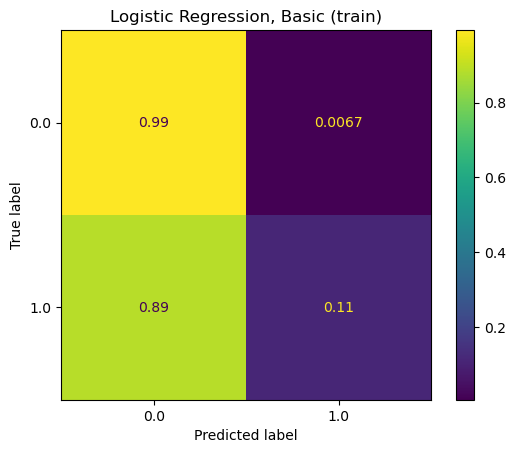


Classification Report: Logistic Regression, Basic (train)
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97 186473339.67118058
         1.0       0.53      0.11      0.18 12790494.337864008

    accuracy                           0.94 199263834.0090446
   macro avg       0.74      0.55      0.58 199263834.0090446
weighted avg       0.92      0.94      0.92 199263834.0090446




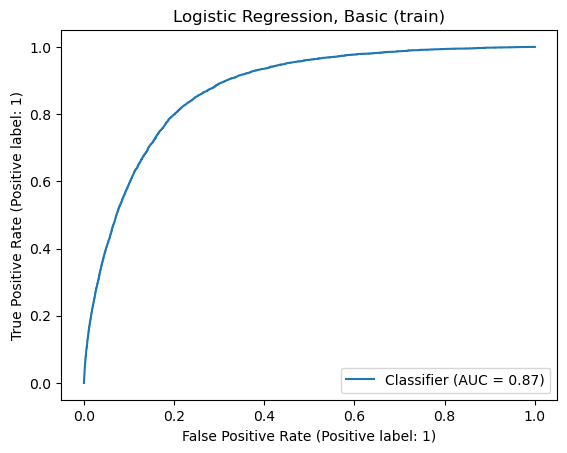

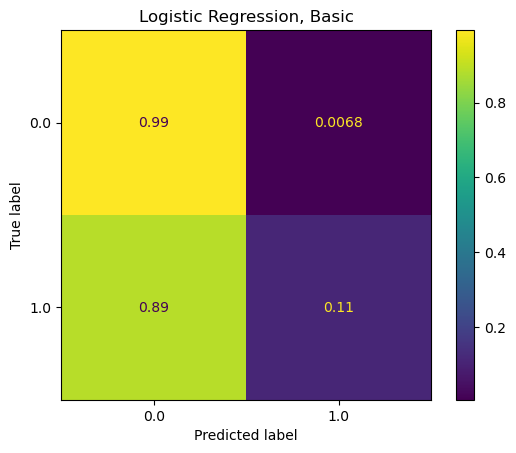


Classification Report: Logistic Regression, Basic
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97 46906559.8130356
         1.0       0.53      0.11      0.19 3218407.048406141

    accuracy                           0.94 50124966.86144174
   macro avg       0.74      0.55      0.58 50124966.86144174
weighted avg       0.92      0.94      0.92 50124966.86144174




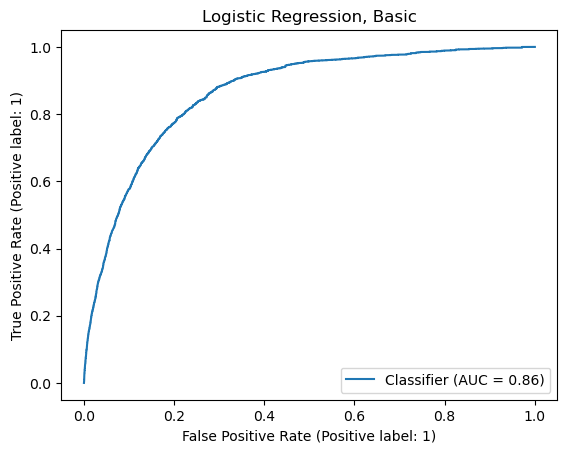

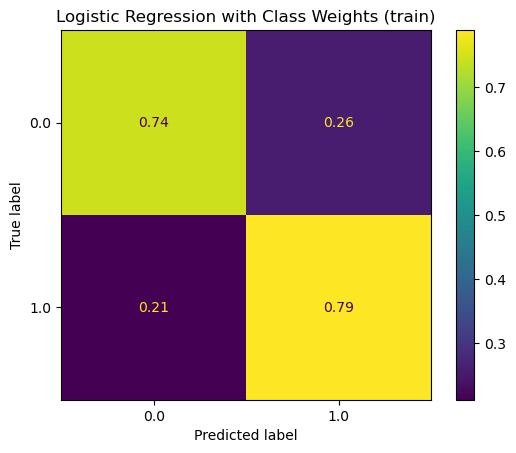


Classification Report: Logistic Regression with Class Weights (train)
              precision    recall  f1-score   support

         0.0       0.97      0.74      0.84    319105
         1.0       0.23      0.79      0.36     30906

    accuracy                           0.75    350011
   macro avg       0.60      0.77      0.60    350011
weighted avg       0.91      0.75      0.80    350011




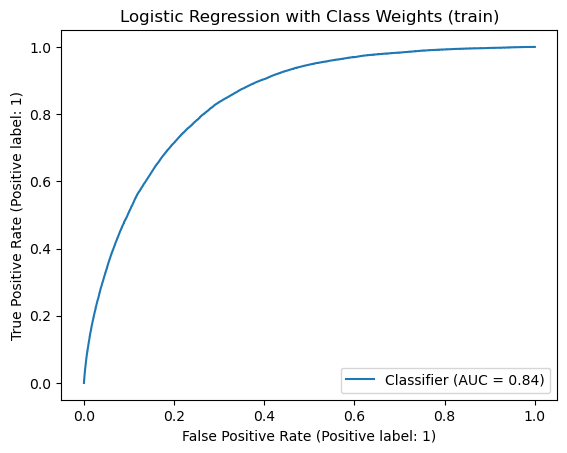

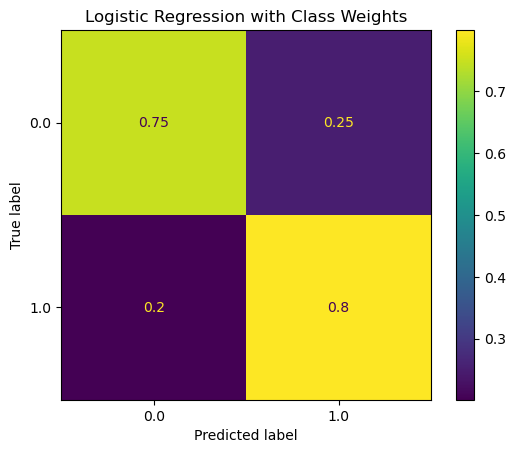


Classification Report: Logistic Regression with Class Weights
              precision    recall  f1-score   support

         0.0       0.97      0.75      0.85     79776
         1.0       0.23      0.80      0.36      7727

    accuracy                           0.75     87503
   macro avg       0.60      0.77      0.60     87503
weighted avg       0.91      0.75      0.80     87503




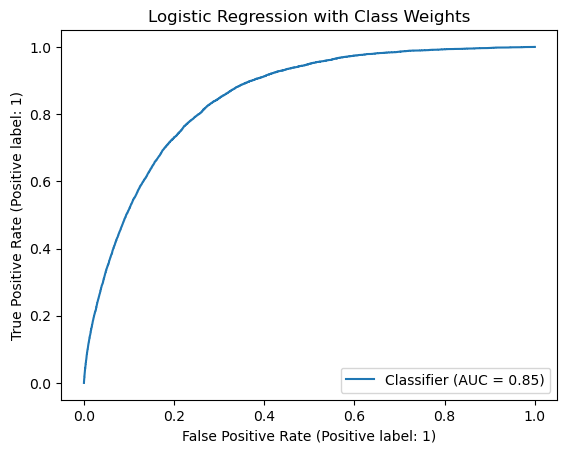

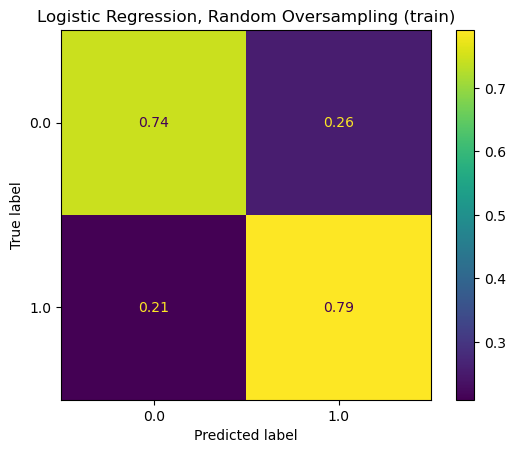


Classification Report: Logistic Regression, Random Oversampling (train)
              precision    recall  f1-score   support

         0.0       0.78      0.74      0.76    319105
         1.0       0.76      0.79      0.77    319105

    accuracy                           0.77    638210
   macro avg       0.77      0.77      0.77    638210
weighted avg       0.77      0.77      0.77    638210




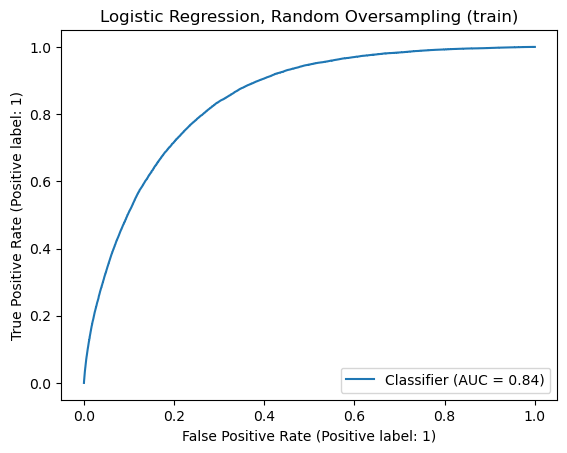

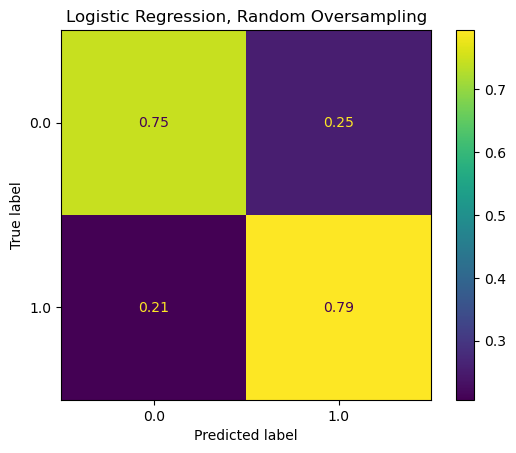


Classification Report: Logistic Regression, Random Oversampling
              precision    recall  f1-score   support

         0.0       0.97      0.75      0.84     79776
         1.0       0.23      0.79      0.36      7727

    accuracy                           0.75     87503
   macro avg       0.60      0.77      0.60     87503
weighted avg       0.91      0.75      0.80     87503




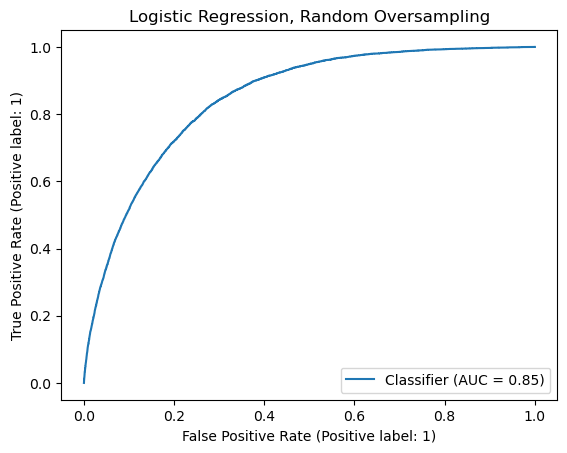

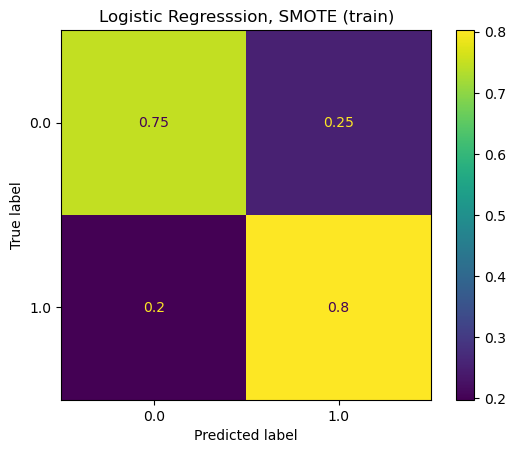


Classification Report: Logistic Regresssion, SMOTE (train)
              precision    recall  f1-score   support

         0.0       0.79      0.75      0.77    319105
         1.0       0.76      0.80      0.78    319105

    accuracy                           0.77    638210
   macro avg       0.78      0.77      0.77    638210
weighted avg       0.78      0.77      0.77    638210




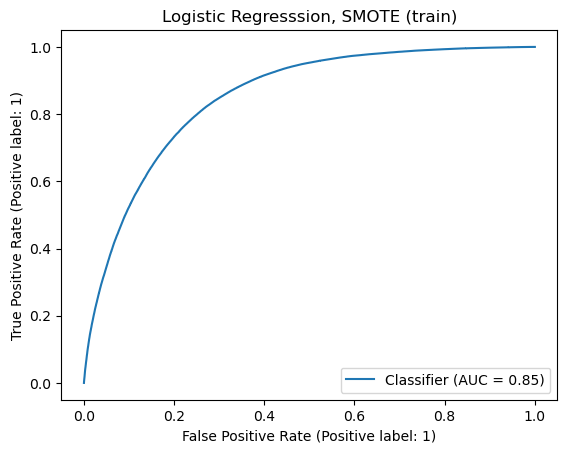

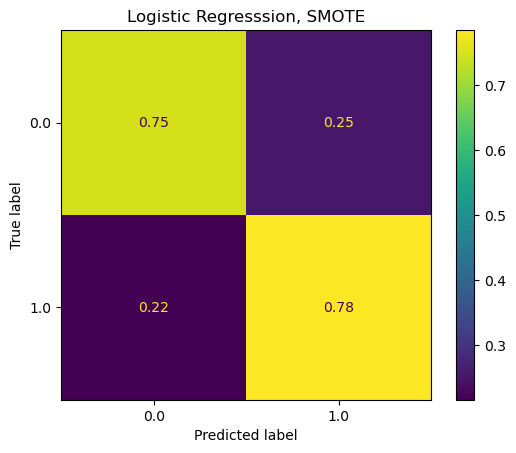


Classification Report: Logistic Regresssion, SMOTE
              precision    recall  f1-score   support

         0.0       0.97      0.75      0.85     79776
         1.0       0.23      0.78      0.36      7727

    accuracy                           0.75     87503
   macro avg       0.60      0.77      0.60     87503
weighted avg       0.91      0.75      0.80     87503




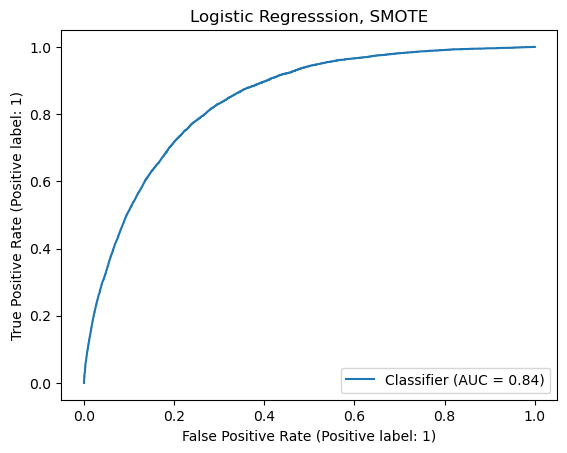

CPU times: user 5min 20s, sys: 4.21 s, total: 5min 24s
Wall time: 4min 51s


{'Logistic Regression, Basic': {'model_info': ('Logistic Regression, Basic',
   LogisticRegressionCustom(max_iter=500)),
  'predictions_train': (array([0., 0., 1., ..., 0., 0., 0.]),
   array([0.21448637, 0.00498464, 0.66535798, ..., 0.01816139, 0.08432861,
          0.01627578])),
  'predictions': (array([0., 0., 0., ..., 0., 0., 0.]),
   array([0.08584859, 0.14365271, 0.19230417, ..., 0.01044634, 0.00944093,
          0.0022811 ])),
  'scores_train': (array([0.94218492, 0.53427077]),
   array([0.99334249, 0.11134459]),
   array([0.96708764, 0.18428359]),
   array([1.86473340e+08, 1.27904943e+07]),
   0.5523435388459441),
  'displays_train': (<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7fc3a599efe0>,
   '              precision    recall  f1-score   support\n\n         0.0       0.94      0.99      0.97 186473339.67118058\n         1.0       0.53      0.11      0.18 12790494.337864008\n\n    accuracy                           0.94 199263834.0090446\n   macro av

In [24]:
%%time
results = {}
for algo, data, model_name, algo_params, resampler in zip(algos, data_list, model_names, algo_params_list, resampler_list):
    results[model_name] = my_pipeline(algo, *data, model_name=model_name, algo_params=algo_params, resampler=resampler, split_params=dict(test_size=0.20, stratify=y))
results

In [25]:
results

{'Logistic Regression, Basic': {'model_info': ('Logistic Regression, Basic',
   LogisticRegressionCustom(max_iter=500)),
  'predictions_train': (array([0., 0., 1., ..., 0., 0., 0.]),
   array([0.21448637, 0.00498464, 0.66535798, ..., 0.01816139, 0.08432861,
          0.01627578])),
  'predictions': (array([0., 0., 0., ..., 0., 0., 0.]),
   array([0.08584859, 0.14365271, 0.19230417, ..., 0.01044634, 0.00944093,
          0.0022811 ])),
  'scores_train': (array([0.94218492, 0.53427077]),
   array([0.99334249, 0.11134459]),
   array([0.96708764, 0.18428359]),
   array([1.86473340e+08, 1.27904943e+07]),
   0.5523435388459441),
  'displays_train': (<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7fc3a599efe0>,
   '              precision    recall  f1-score   support\n\n         0.0       0.94      0.99      0.97 186473339.67118058\n         1.0       0.53      0.11      0.18 12790494.337864008\n\n    accuracy                           0.94 199263834.0090446\n   macro av

In [18]:
%%time
cv_results = {}
for algo, data, model_name, algo_params, resampler in zip(algos, data_list, model_names, algo_params_list, resampler_list):
    cv_results.update(cv_scorer(algo, scores, *data, model_name=model_name, algo_params=algo_params, resampler=resampler))
cv_results

Logistic Regression, Basic cv_scores:
{'fit_time': array([43.04972053, 44.25779486, 46.31534791, 46.34921885, 45.99820495]), 'score_time': array([0.36099219, 0.39701891, 0.34886909, 0.39084458, 0.32685852]), 'test_precision_pos': array([0.51930502, 0.53601815, 0.53558844, 0.51607445, 0.53413655]), 'test_precision_neg': array([0.91949877, 0.9209004 , 0.91906742, 0.92054123, 0.92076633]), 'test_recall_pos': array([0.1044525 , 0.12229843, 0.09835641, 0.11841594, 0.1205022 ]), 'test_recall_neg': array([0.9906364 , 0.98974629, 0.99173937, 0.98924489, 0.9898215 ]), 'test_f1_pos': array([0.17392241, 0.19915701, 0.16619287, 0.19263158, 0.19664167]), 'test_f1_neg': array([0.95374293, 0.95408299, 0.95402146, 0.95365727, 0.95404597]), 'test_roc_auc': array([0.54754445, 0.55602236, 0.54504789, 0.55383041, 0.55516185])}

precision_pos mean: 0.53
precision_pos std: 0.0087

precision_neg mean: 0.92
precision_neg std: 0.0007

recall_pos mean: 0.11
recall_pos std: 0.0096

recall_neg mean: 0.99
recall_n

{'Logistic Regression, Basic': {'precision_pos': {'scores': array([0.51930502, 0.53601815, 0.53558844, 0.51607445, 0.53413655]),
   'mean': 0.528224521803746,
   'std': 0.008684489426936509},
  'precision_neg': {'scores': array([0.91949877, 0.9209004 , 0.91906742, 0.92054123, 0.92076633]),
   'mean': 0.9201548318525752,
   'std': 0.0007337548170555462},
  'recall_pos': {'scores': array([0.1044525 , 0.12229843, 0.09835641, 0.11841594, 0.1205022 ]),
   'mean': 0.11280509783094139,
   'std': 0.009585205729773574},
  'recall_neg': {'scores': array([0.9906364 , 0.98974629, 0.99173937, 0.98924489, 0.9898215 ]),
   'mean': 0.9902376889380291,
   'std': 0.0008734255639947328},
  'f1_pos': {'scores': array([0.17392241, 0.19915701, 0.16619287, 0.19263158, 0.19664167]),
   'mean': 0.18570910882886044,
   'std': 0.013176473234431347},
  'f1_neg': {'scores': array([0.95374293, 0.95408299, 0.95402146, 0.95365727, 0.95404597]),
   'mean': 0.9539101238567635,
   'std': 0.00017471382537394373},
  'roc_

In [23]:
cv_results

{'Logistic Regression, Basic': {'precision_pos': {'scores': array([0.51930502, 0.53601815, 0.53558844, 0.51607445, 0.53413655]),
   'mean': 0.528224521803746,
   'std': 0.008684489426936509},
  'precision_neg': {'scores': array([0.91949877, 0.9209004 , 0.91906742, 0.92054123, 0.92076633]),
   'mean': 0.9201548318525752,
   'std': 0.0007337548170555462},
  'recall_pos': {'scores': array([0.1044525 , 0.12229843, 0.09835641, 0.11841594, 0.1205022 ]),
   'mean': 0.11280509783094139,
   'std': 0.009585205729773574},
  'recall_neg': {'scores': array([0.9906364 , 0.98974629, 0.99173937, 0.98924489, 0.9898215 ]),
   'mean': 0.9902376889380291,
   'std': 0.0008734255639947328},
  'f1_pos': {'scores': array([0.17392241, 0.19915701, 0.16619287, 0.19263158, 0.19664167]),
   'mean': 0.18570910882886044,
   'std': 0.013176473234431347},
  'f1_neg': {'scores': array([0.95374293, 0.95408299, 0.95402146, 0.95365727, 0.95404597]),
   'mean': 0.9539101238567635,
   'std': 0.00017471382537394373},
  'roc_

In [20]:
columns = []
for score in scores:
    columns.append(score + ' mean')
    columns.append(score + ' std')
    
data = []
index = []
for model_name in cv_results:
    index.append(model_name)
    row = []
    for score in cv_results[model_name]:
        row.append(cv_results[model_name][score]['mean'])
        row.append(cv_results[model_name][score]['std'])
    data.append(row)
columns, index, data

(['precision_pos mean',
  'precision_pos std',
  'precision_neg mean',
  'precision_neg std',
  'recall_pos mean',
  'recall_pos std',
  'recall_neg mean',
  'recall_neg std',
  'f1_pos mean',
  'f1_pos std',
  'f1_neg mean',
  'f1_neg std',
  'roc_auc mean',
  'roc_auc std'],
 ['Logistic Regression, Basic',
  'Logistic Regression with Class Weights',
  'Logistic Regression, Random Oversampling',
  'Logistic Regresssion, SMOTE'],
 [[0.528224521803746,
   0.008684489426936509,
   0.9201548318525752,
   0.0007337548170555462,
   0.11280509783094139,
   0.009585205729773574,
   0.9902376889380291,
   0.0008734255639947328,
   0.18570910882886044,
   0.013176473234431347,
   0.9539101238567635,
   0.00017471382537394373,
   0.5515213933844851,
   0.004394668180718683],
  [0.23083992055828317,
   0.0043362148780784985,
   0.9734057976638514,
   0.0011744141810208256,
   0.7897390135232529,
   0.012061665161959398,
   0.7449414683110277,
   0.009699634504918337,
   0.357187240546227,
   0.00

In [21]:
results_df = pd.DataFrame(data, index=index, columns=columns)
results_df

,precision_pos mean,precision_pos std,precision_neg mean,precision_neg std,recall_pos mean,recall_pos std,recall_neg mean,recall_neg std,f1_pos mean,f1_pos std,f1_neg mean,f1_neg std,roc_auc mean,roc_auc std
"Logistic Regression, Basic",0.528225,0.008684,0.920155,0.000734,0.112805,0.009585,0.990238,0.000873,0.185709,0.013176,0.953910,0.000175,0.551521,0.004395
Logistic Regression with Class Weights,0.230840,0.004336,0.973406,0.001174,0.789739,0.012062,0.744941,0.009700,0.357187,0.004148,0.843944,0.005814,0.767340,0.002092
"Logistic Regression, Random Oversampling",0.230776,0.004411,0.973403,0.001219,0.789739,0.012499,0.744841,0.009952,0.357107,0.004185,0.843877,0.005957,0.767290,0.002125
"Logistic Regresssion, SMOTE",0.229852,0.002548,0.972209,0.001364,0.779411,0.013331,0.746970,0.007796,0.354963,0.001957,0.844805,0.004506,0.763190,0.002997


In [26]:
with open('../Data/modeling_results.pkl', 'wb') as f:
    pickle.dump(results, f)
    pickle.dump(cv_results, f)

In [ ]:
plot_logistic_feature_importance(log_regressor.coef_[0], log_regressor.feature_names_in_, 20)